In [156]:
#import necessary packages  
import pandas as pd
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import plotly.express as px

#qq plot
import statsmodels.api as sm
from scipy.stats import norm
import pylab

#shapiro wilk test
from scipy.stats import shapiro

#binary correlation
from scipy.stats import pointbiserialr

import datetime

# Extracting Seattle's data

In [157]:
#read csv file
airbnb = pd.read_csv('/Users/bernicelow/Documents/capstone/seattle_listings.csv')

In [158]:
#basic info of airbnb data
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [159]:
airbnb.isnull().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64

In [160]:
#drop columns 
columns_to_drop = ['listing_url','scrape_id','last_scraped', 'summary', 'space', 'description', 'experiences_offered', 
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 
                   'picture_url', 'xl_picture_url', 'host_id','host_name','host_location', 'host_about',
                   'host_neighbourhood', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_total_listings_count',
                   'street', 'neighbourhood_cleansed','neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 
                   'country', 'latitude', 'longitude', 'is_location_exact', 'square_feet', 'weekly_price', 'monthly_price',
                   'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_60', 'availability_90',
                   'availability_365', 'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count',
                   'reviews_per_month']
airbnb = airbnb.drop(columns = columns_to_drop)   

In [161]:
#fill up the missing values with mode
airbnb['bathrooms'] = airbnb['bathrooms'].fillna(airbnb['bathrooms'].mode()[0])
airbnb['bedrooms'] = airbnb['bedrooms'].fillna(airbnb['bedrooms'].mode()[0])
airbnb['beds'] = airbnb['beds'].fillna(airbnb['beds'].mode()[0])

In [162]:
#fill up missing values with mode
airbnb['review_scores_rating'] = airbnb['review_scores_rating'].fillna(airbnb['review_scores_rating'].mode()[0])
airbnb['review_scores_accuracy'] = airbnb['review_scores_accuracy'].fillna(airbnb['review_scores_accuracy'].mode()[0])
airbnb['review_scores_checkin'] = airbnb['review_scores_checkin'].fillna(airbnb['review_scores_checkin'].mode()[0])
airbnb['review_scores_communication'] = airbnb['review_scores_communication'].fillna(airbnb['review_scores_communication'].mode()[0])
airbnb['review_scores_location'] = airbnb['review_scores_location'].fillna(airbnb['review_scores_location'].mode()[0])
airbnb['review_scores_value'] = airbnb['review_scores_value'].fillna(airbnb['review_scores_value'].mode()[0])

In [163]:
#remove $ and replace to blanks
airbnb['price'] = airbnb['price'].str.replace('$', '').str.replace(',', '').astype(float)
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
airbnb['security_deposit'] = airbnb['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)

In [164]:
#fill up missing value with median
airbnb['cleaning_fee'].fillna(airbnb['cleaning_fee'].median(), inplace=True)

In [165]:
#fill up missing value with median 
airbnb['security_deposit'].fillna(airbnb['security_deposit'].median(), inplace=True)

In [166]:
def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

In [167]:
airbnb['extra_people_fee'] = airbnb.apply(lambda row: get_extra_people_fee(row),axis=1)
airbnb = airbnb.drop(columns = ['extra_people'])

In [168]:
#check duplicates

duplicateRows = airbnb[airbnb.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [id, name, host_since, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, neighbourhood_group_cleansed, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, price, security_deposit, cleaning_fee, guests_included, availability_30, calendar_last_scraped, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, cancellation_policy, extra_people_fee]
Index: []

[0 rows x 36 columns]


In [169]:
features = airbnb.columns.sort_values(ascending = True).tolist()

In [170]:
for feature in features:
    print(feature)
    print(airbnb[feature][:5] , "\n")

accommodates
0     4
1     4
2    11
3     3
4     6
Name: accommodates, dtype: int64 

amenities
0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object 

availability_30
0    14
1    13
2     1
3     0
4    30
Name: availability_30, dtype: int64 

bathrooms
0    1.0
1    1.0
2    4.5
3    1.0
4    2.0
Name: bathrooms, dtype: float64 

bed_type
0    Real Bed
1    Real Bed
2    Real Bed
3    Real Bed
4    Real Bed
Name: bed_type, dtype: object 

bedrooms
0    1.0
1    1.0
2    5.0
3    0.0
4    3.0
Name: bedrooms, dtype: float64 

beds
0    1.0
1    1.0
2    7.0
3    2.0
4    3.0
Name: beds, dtype: float64 

calendar_last_scraped
0    2016-01-04
1    2016-01-04
2    2016-01-04
3    2016-01-04
4    2016-01-04
Name: calendar_last_scraped, dty

In [23]:
airbnb = pd.get_dummies(airbnb, columns=['property_type', 'room_type', 'host_response_time'])

# Property type 

In [171]:
proptype = airbnb[['property_type','price', 'host_is_superhost']]
proptype2 = proptype.groupby(['property_type']).mean().sort_values(['price'],ascending=False)
proptype2['Count'] = airbnb['property_type'].value_counts()
proptype2 = proptype2.reset_index()
proptype = proptype2.rename(columns={'price':'Mean Price (USD)', 'property_type': 'Property type'})

proptype

,Property type,Mean Price (USD),Count
0,Boat,282.375000,8
1,Condominium,151.109890,91
2,Loft,135.700000,40
3,House,132.351414,1733
4,Townhouse,129.457627,118
5,Apartment,122.932670,1708
6,Camper/RV,120.461538,13
7,Bungalow,115.615385,13
8,Bed & Breakfast,112.054054,37
9,Cabin,104.666667,21


Text(0.5, 1.0, 'The frequency of each property type ')

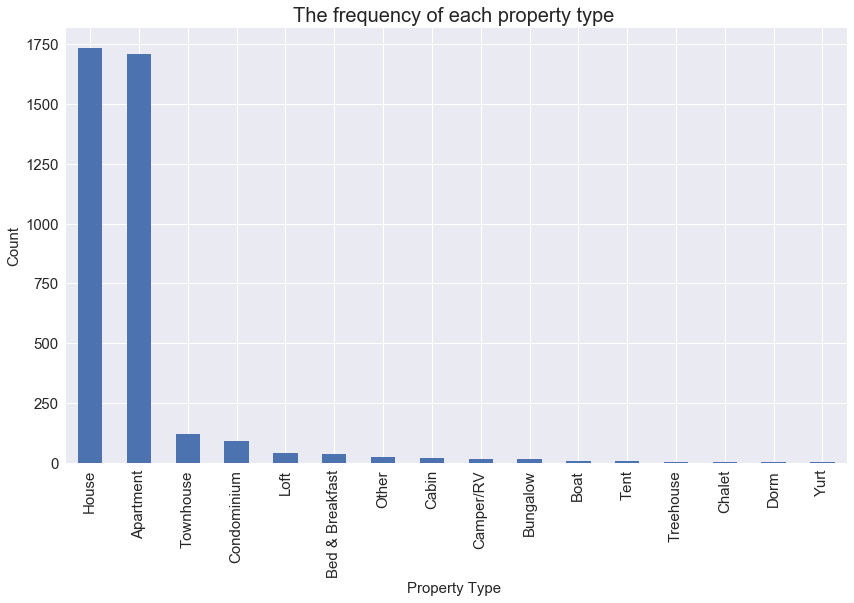

In [172]:
ax = airbnb['property_type'].value_counts().plot(kind='bar',
                                   figsize=(14,8),
                                    fontsize = 15)
ax.set_xlabel("Property Type ", fontsize = 15)
ax.set_ylabel("Count", fontsize = 15)
ax.set_title("The frequency of each property type ", fontsize = 20)

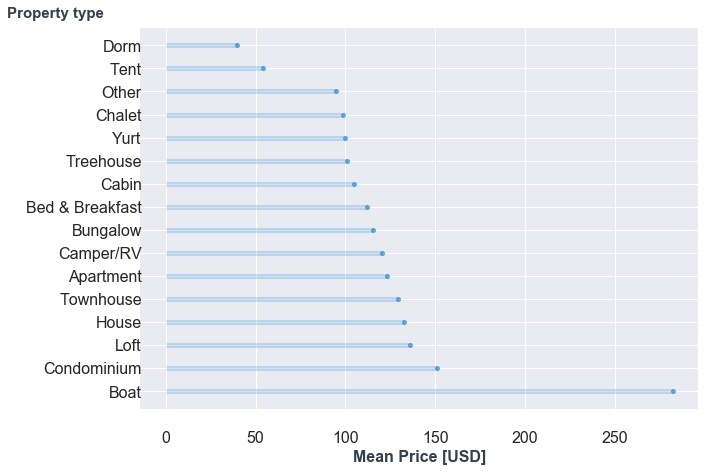

In [173]:
my_range=list(range(1,len(proptype.index)+1))

fig, ax = plt.subplots(figsize=(5*2,3.5*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=proptype['Mean Price (USD)'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(proptype['Mean Price (USD)'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Mean Price [USD]', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, proptype['Property type'])

# add an horizonal label for the y axis 
fig.text(-0.06, 0.9, 'Property type', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))

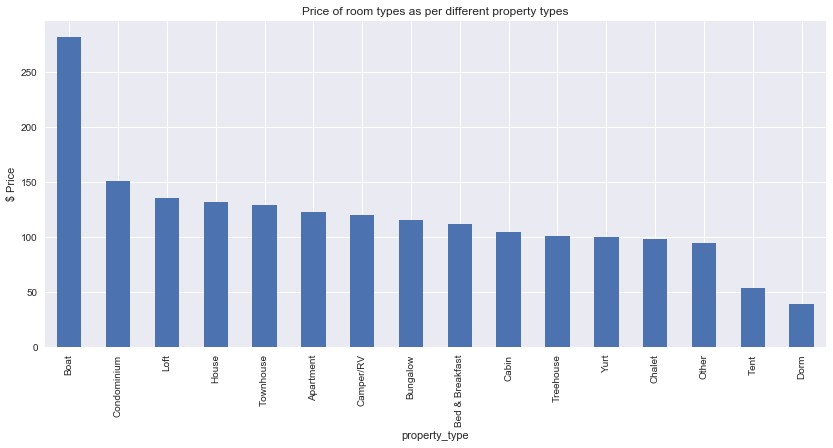

In [174]:
plt.figure(figsize=(14,6))
airbnb.groupby(['property_type'])['price'].mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Price of room types as per different property types');
plt.ylabel('$ Price');

In [175]:
#group those property type into smaller groups

def label_states (row):
    if row['property_type'] in ['Apartment', 'Condominium']:
        return 'Apartment'
    if row['property_type'] in ['Loft']:
        return 'Loft'
    if row['property_type'] in ['Townhouse', 'House', 'Bungalow']:
        return 'House'
    if row['property_type'] in ['Boat','Cabin','Camper/RV','Dorm','Chalet','Tent','Treehouse','Yurt','Other']:
        return 'Other'
    if row['property_type'] in ['Bed & Breakfast']:
        return 'Bed & Breakfast'

airbnb['property_type'] = airbnb.apply(lambda row: label_states(row), axis=1)

In [176]:
airbnb = pd.get_dummies(airbnb, columns=['property_type'])

# Amenities

In [177]:
airbnb.loc[airbnb['amenities'] == '{}','amenities'] = ""

In [178]:
airbnb['amenities'] = airbnb['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))

In [179]:
#Take the unique list of amenities across all listings
amenities = np.unique(np.concatenate(airbnb['amenities'].map(lambda amns: amns.split("|")).values))
amenities

array(['', '24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer',
       'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet',
       'Iron', 'Kitchen', 'Laptop Friendly Workspace',
       'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed',
       'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo',
       'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV',
       'Washer', 'Washer / Dryer', 'Wheelchair Accessible',
       'Wireless Internet'], dtype='<U26')

In [180]:
amenities_matrix = np.array([airbnb['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
amenities_matrix

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [181]:
amen=pd.DataFrame(data=amenities_matrix.T, columns=amenities)
amen.head()

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
1,True,False,False,False,True,False,True,False,False,False,...,True,False,True,False,False,True,True,False,False,True
2,True,False,True,False,False,True,True,True,True,False,...,False,True,True,False,False,True,True,False,False,True
3,True,False,False,False,False,False,True,False,False,False,...,True,True,True,False,False,False,True,False,False,True
4,True,False,False,False,False,True,True,False,False,False,...,False,True,True,False,False,True,False,False,False,True


In [182]:
airbnb_amenities = pd.concat([amen,airbnb['id']], axis=1)
airbnb_amenities.head()

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,id
0,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,True,False,False,True,241032
1,True,False,False,False,True,False,True,False,False,False,...,False,True,False,False,True,True,False,False,True,953595
2,True,False,True,False,False,True,True,True,True,False,...,True,True,False,False,True,True,False,False,True,3308979
3,True,False,False,False,False,False,True,False,False,False,...,True,True,False,False,False,True,False,False,True,7421966
4,True,False,False,False,False,True,True,False,False,False,...,True,True,False,False,True,False,False,False,True,278830


In [183]:
airbnb_amenities=airbnb_amenities.drop("",axis=1)
airbnb_amenities.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,id
0,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,True,241032
1,False,False,False,True,False,True,False,False,False,True,...,False,True,False,False,True,True,False,False,True,953595
2,False,True,False,False,True,True,True,True,False,True,...,True,True,False,False,True,True,False,False,True,3308979
3,False,False,False,False,False,True,False,False,False,True,...,True,True,False,False,False,True,False,False,True,7421966
4,False,False,False,False,True,True,False,False,False,False,...,True,True,False,False,True,False,False,False,True,278830


In [184]:
amenity_recode={
                'Air Conditioning':'Weather Control',
                'Indoor Fireplace':'Weather Control',
                'Heating':'Weather Control',
        
                'Carbon Monoxide Detector':'Safety Features',
                'Fire Extinguisher':'Safety Features',
                'First Aid Kit':'Safety Features',
                'Smoke Detector':'Safety Features',
                
                'Buzzer/Wireless Intercom':'Security Features',
                'Doorman':'Security Features',
                'Safety Card':'Security Features',
                'Lock on Bedroom Door':'Security Features',
                
                'Cat(s)':'Pet Friendly',
                'Dog(s)':'Pet Friendly',
                'Pets Allowed':'Pet Friendly',
                'Pets live on this property':'Pet Friendly',
                'Other pet(s)':'Pet Friendly',
                
                'Elevator in Building':'Access Friendly',
                'Wheelchair Accessible':'Access Friendly',
                
                'Essentials':'Essentials',
                'Hair Dryer':'Essentials',
                'Hangers':'Essentials',
                'Iron':'Essentials',
                'Shampoo':'Essentials',             
                
                'Cable TV':'TV',
                'TV':'TV',
                
                'Internet':'Internet',
                'Wireless Internet':'Internet',
                'Laptop Friendly Workspace':'Internet',
                
                'Dryer':'Laundry Facility',
                'Washer':'Laundry Facility',
                'Washer / Dryer':'Laundry Facility',
    
            
}

In [185]:
airbnb_amenities_melt = airbnb_amenities.melt(id_vars=['id'], var_name='amenity')

#Recoding and putting in new column called amenity_modified
airbnb_amenities_melt = airbnb_amenities_melt.assign(amenity_modified = airbnb_amenities_melt.amenity.replace(amenity_recode))

airbnb_amenities_melt.head()

,id,amenity,value,amenity_modified
0,241032,24-Hour Check-in,False,24-Hour Check-in
1,953595,24-Hour Check-in,False,24-Hour Check-in
2,3308979,24-Hour Check-in,False,24-Hour Check-in
3,7421966,24-Hour Check-in,False,24-Hour Check-in
4,278830,24-Hour Check-in,False,24-Hour Check-in


In [186]:
airbnb_amenities_pivot = airbnb_amenities_melt.pivot_table(
    index='id',
    columns='amenity_modified',
    values='value', 
    aggfunc='max'
)

airbnb_amenities_pivot.head()

amenity_modified,24-Hour Check-in,Access Friendly,Breakfast,Essentials,Family/Kid Friendly,Free Parking on Premises,Gym,Hot Tub,Internet,Kitchen,Laundry Facility,Pet Friendly,Pool,Safety Features,Security Features,Smoking Allowed,Suitable for Events,TV,Weather Control
id,,,,,,,,,,,,,,,,,,,
3335,False,False,False,False,True,True,False,False,True,True,True,True,False,True,False,False,False,False,True
4291,False,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,False,True,True
5682,True,False,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False,True,True
6606,False,False,False,True,False,True,False,True,True,True,False,True,False,False,False,False,False,True,True
7369,False,True,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False,True,True


In [187]:
airbnb_joined=airbnb.join(airbnb_amenities_pivot,on="id",how="inner")
airbnb_joined.head()

,id,name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,Kitchen,Laundry Facility,Pet Friendly,Pool,Safety Features,Security Features,Smoking Allowed,Suitable for Events,TV,Weather Control
0,241032,Stylish Queen Anne Apartment,2011-08-11,within a few hours,96%,100%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,...,True,True,False,False,False,False,False,False,True,True
1,953595,Bright & Airy Queen Anne Apartment,2013-02-21,within an hour,98%,100%,t,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,...,True,True,False,False,True,True,False,False,True,True
2,3308979,New Modern House-Amazing water view,2014-06-12,within a few hours,67%,100%,f,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,...,True,True,True,False,True,False,False,False,True,True
3,7421966,Queen Anne Chateau,2013-11-06,NaN,NaN,NaN,f,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,...,True,True,False,False,True,True,False,False,False,True
4,278830,Charming craftsman 3 bdm house,2011-11-29,within an hour,100%,NaN,f,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,...,True,False,False,False,True,False,False,False,True,True


In [188]:
#check the correlation of price and amenities

price = airbnb_joined['price']
check_in = airbnb_joined['24-Hour Check-in']
access = airbnb_joined['Access Friendly']
breakf = airbnb_joined['Breakfast']
essen = airbnb_joined['Essentials']
fam = airbnb_joined['Family/Kid Friendly']
free = airbnb_joined['Free Parking on Premises']
g = airbnb_joined['Gym']
hot = airbnb_joined['Hot Tub']
inter = airbnb_joined['Internet']
kit = airbnb_joined['Kitchen']
laundry = airbnb_joined['Laundry Facility']
pet = airbnb_joined['Pet Friendly']
po = airbnb_joined['Pool']
safety = airbnb_joined['Safety Features']
smoke = airbnb_joined['Smoking Allowed']
event = airbnb_joined['Suitable for Events']
tv = airbnb_joined['TV']
weather = airbnb_joined['Weather Control']

In [189]:
pointbiserialr(price,check_in)

PointbiserialrResult(correlation=0.017459329218720784, pvalue=0.28079269724581646)

In [190]:
pointbiserialr(price, access)

PointbiserialrResult(correlation=0.0919961830988413, pvalue=1.2361888654517301e-08)

In [191]:
pointbiserialr(price, breakf)

PointbiserialrResult(correlation=-0.10296541158116941, pvalue=1.8047106957069854e-10)

In [192]:
pointbiserialr(price,essen)

PointbiserialrResult(correlation=-0.0010630113766704084, pvalue=0.9476469677208923)

In [193]:
pointbiserialr(price,fam)

PointbiserialrResult(correlation=0.25990058032268715, pvalue=5.518231834373802e-60)

In [194]:
pointbiserialr(price,free)

PointbiserialrResult(correlation=0.07940773644216338, pvalue=8.980608014505472e-07)

In [195]:
pointbiserialr(price, g)

PointbiserialrResult(correlation=0.11375713283270986, pvalue=1.7937893719404724e-12)

In [196]:
pointbiserialr(price, hot)

PointbiserialrResult(correlation=0.12706577581839792, pvalue=3.253406264484735e-15)

In [197]:
pointbiserialr(price,inter)

PointbiserialrResult(correlation=0.019795763606504566, pvalue=0.2213678943925601)

In [198]:
pointbiserialr(price,kit)

PointbiserialrResult(correlation=0.12502434091786274, pvalue=8.96351133979742e-15)

In [199]:
pointbiserialr(price,laundry)

PointbiserialrResult(correlation=0.10900481800007039, pvalue=1.4448991680351525e-11)

In [200]:
pointbiserialr(price,pet)

PointbiserialrResult(correlation=-0.045630931172512865, pvalue=0.004801177059574269)

In [201]:
pointbiserialr(price,po)

PointbiserialrResult(correlation=0.09914148749797784, pvalue=8.30047325217516e-10)

In [202]:
pointbiserialr(price,safety)

PointbiserialrResult(correlation=0.02447930184421712, pvalue=0.1304558919537547)

In [203]:
pointbiserialr(price,smoke)

PointbiserialrResult(correlation=-0.057202679536773125, pvalue=0.0004057890685632143)

In [204]:
pointbiserialr(price,event)

PointbiserialrResult(correlation=0.08693210267541486, pvalue=7.450242488238326e-08)

In [205]:
pointbiserialr(price,tv)

PointbiserialrResult(correlation=0.22248846661842075, pvalue=4.935320205531108e-44)

In [206]:
pointbiserialr(price,weather)

PointbiserialrResult(correlation=0.019813138885975478, pvalue=0.22096261873654)

# Host characteristics

In [207]:
set(airbnb['host_has_profile_pic'])
airbnb['host_has_profile_pic'].fillna('f',inplace=True)

In [208]:
#fill missing values with mean 
airbnb['host_listings_count'].fillna(airbnb['host_listings_count'].mean(), inplace = True)

In [209]:
def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

In [210]:
def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

In [211]:
def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(airbnb, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in airbnb[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        airbnb[column_name + '_' + value[0]] = airbnb.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

In [212]:
split_list_into_columns(airbnb, 'host_verifications')
airbnb = airbnb.drop(columns = ['host_verifications'])

In [213]:
airbnb['host_response_rate_num'] = airbnb['host_response_rate'].astype(str)
airbnb['host_response_rate_num'] = airbnb['host_response_rate_num'].str.replace("%", "").astype("float")
airbnb['host_response_rate_num'].fillna(airbnb['host_response_rate_num'].mean(), inplace = True)
airbnb['host_response_rate_buckets'] = pd.qcut(airbnb['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
airbnb = airbnb.drop(columns = ['host_response_rate', 'host_response_rate_num'])

In [214]:
def recode_prop(value):
        if value in ['t']:
            return 1.0
        else: 
            return 0.0

airbnb['host_is_superhost'] = airbnb['host_is_superhost'].apply(recode_prop)

def recode_prop(value):
        if value in ['t']:
            return 1.0
        else: 
            return 0.0

airbnb['host_has_profile_pic'] = airbnb['host_has_profile_pic'].apply(recode_prop)

def recode_prop(value):
        if value in ['t']:
            return 1.0
        else: 
            return 0.0

airbnb['host_identity_verified'] = airbnb['host_identity_verified'].apply(recode_prop)


In [215]:
airbnb['host_since_year'] = airbnb.apply(lambda row: get_host_since_year(row),axis=1)
airbnb['host_since_year'].fillna(airbnb['host_since_year'].mean(), inplace = True)
airbnb = airbnb.drop(columns = ['host_since'])

In [216]:
#Get the year of host since to 2016 
years = 2016
airbnb['host_year_difference'] = years - airbnb['host_since_year'] 

Text(0.5, 1.0, 'Host Identity Verified ')

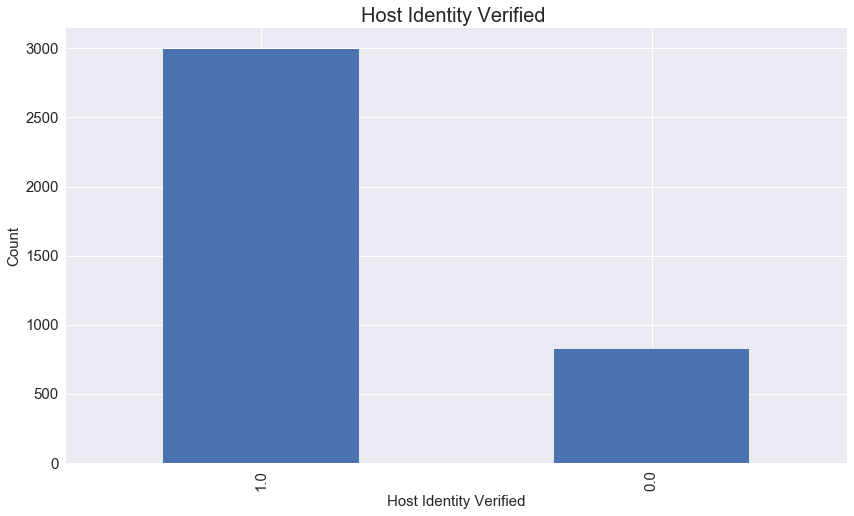

In [217]:
h = airbnb['host_identity_verified'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    fontsize = 15)
h.set_xlabel("Host Identity Verified", fontsize = 15)
h.set_ylabel("Count", fontsize = 15)
h.set_title("Host Identity Verified ", fontsize = 20)

Text(0.5, 1.0, 'Host with or without Profile Picture ')

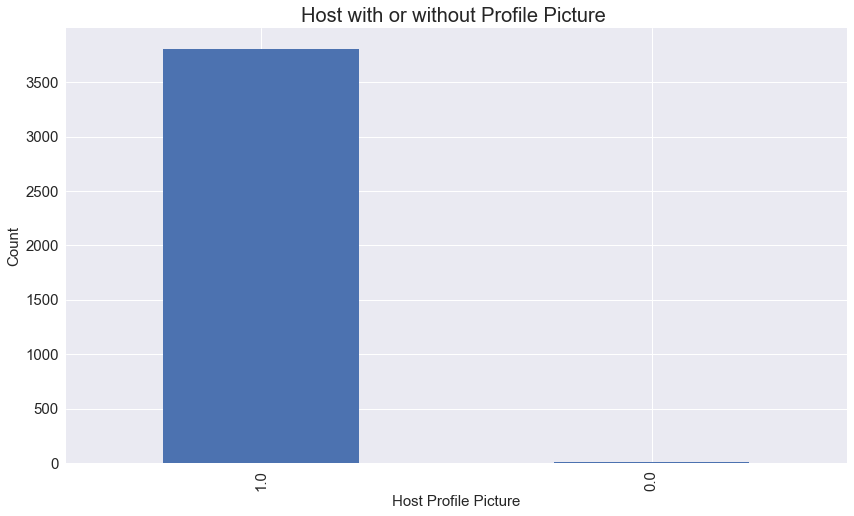

In [218]:
profile = airbnb['host_has_profile_pic'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    fontsize = 15)
profile.set_xlabel("Host Profile Picture", fontsize = 15)
profile.set_ylabel("Count", fontsize = 15)
profile.set_title("Host with or without Profile Picture ", fontsize = 20)

In [219]:
availabilty = airbnb['availability_30']
response = airbnb['host_response_rate_buckets']
superhost = airbnb['host_is_superhost']
profile_pic = airbnb['host_has_profile_pic']
verified = airbnb['host_identity_verified']

In [220]:
pointbiserialr(availabilty,response)

PointbiserialrResult(correlation=0.052358728217628596, pvalue=0.0012104566427618196)

In [221]:
pointbiserialr(availabilty,superhost)

PointbiserialrResult(correlation=0.01342343866428433, pvalue=0.40699147642237143)

In [222]:
pointbiserialr(availabilty,profile_pic)

PointbiserialrResult(correlation=-0.027920475575168625, pvalue=0.08453168790238497)

In [223]:
pointbiserialr(availabilty,verified)

PointbiserialrResult(correlation=0.022130000259137316, pvalue=0.1715840476047944)

In [224]:
airbnb = pd.get_dummies(airbnb, columns=['host_response_time'])

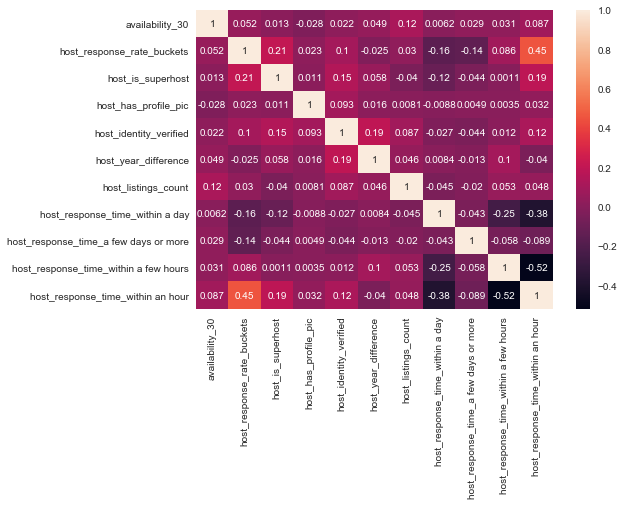

In [225]:
col = ['availability_30','host_response_rate_buckets', 'host_is_superhost', 'host_has_profile_pic','host_identity_verified', 'host_year_difference', 'host_listings_count',
       'host_response_time_within a day', 'host_response_time_a few days or more','host_response_time_within a few hours',
       'host_response_time_within an hour']
df = airbnb[col]
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

# Neighbourhood group

In [226]:
#Get the neighbourhood group and average price of listing in USD
price_analysis = airbnb.copy()
neigh_price = price_analysis.groupby(['neighbourhood_group_cleansed']).mean().sort_values(['price'],ascending=False).reset_index()
neigh_price = neigh_price[['neighbourhood_group_cleansed','price']]
neigh_price = neigh_price.rename(columns={"neighbourhood_group_cleansed": "Neighbourhood", "price": "Mean Price (USD)"})
neigh_price

,Neighbourhood,Mean Price (USD)
0,Magnolia,177.672131
1,Queen Anne,157.223729
2,Downtown,154.405660
3,West Seattle,141.359606
4,Cascade,140.101124
5,Capitol Hill,130.592593
6,Central Area,128.338753
7,Ballard,124.682609
8,Other neighborhoods,119.968514
9,Interbay,109.727273


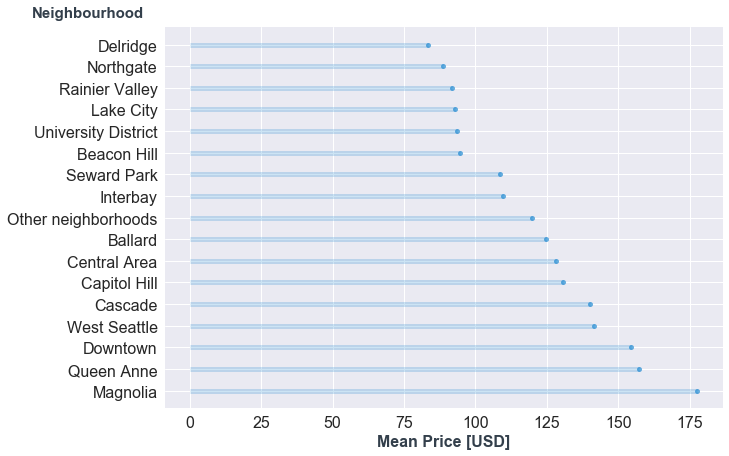

In [227]:
my_range=list(range(1,len(neigh_price.index)+1))

fig, ax = plt.subplots(figsize=(5*2,3.5*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=neigh_price['Mean Price (USD)'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(neigh_price['Mean Price (USD)'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Mean Price [USD]', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, neigh_price['Neighbourhood'])

# add an horizonal label for the y axis 
fig.text(-0.06, 0.9, 'Neighbourhood', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

In [228]:
airbnb.neighbourhood_group_cleansed.unique()

array(['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City'], dtype=object)

In [229]:
#Queen Anne
sub_1=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Queen Anne']
price_sub1=sub_1[['price']]
#Ballard
sub_2=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Ballard']
price_sub2=sub_2[['price']]
#Other neighborhoods
sub_3=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Other neighborhoods']
price_sub3=sub_3[['price']]
#Cascade
sub_4=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Cascade']
price_sub4=sub_4[['price']]
#Central Area
sub_5=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Central Area']
price_sub5=sub_5[['price']]
#University District 
sub_6=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'University District']
price_sub6=sub_6[['price']]
#Downtown
sub_7=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Downtown']
price_sub7=sub_7[['price']]
#Magnolia
sub_8=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Magnolia']
price_sub8=sub_8[['price']]
#West Seattle
sub_9=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'West Seattle']
price_sub9=sub_9[['price']]
#Interbay
sub_10=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Interbay']
price_sub10=sub_10[['price']]
#Beacon Hill
sub_11=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Beacon Hill']
price_sub11=sub_11[['price']]
#Rainier Valley
sub_12=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Rainier Valley']
price_sub12=sub_12[['price']]
#Delridge
sub_13=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Delridge']
price_sub13=sub_13[['price']]
#Seward Park
sub_14=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Seward Park']
price_sub14=sub_14[['price']]
#Northgate
sub_15=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Northgate']
price_sub15=sub_15[['price']]
#Capitol Hill
sub_16=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Capitol Hill']
price_sub16=sub_16[['price']]
#Lake City 
sub_17=airbnb.loc[airbnb['neighbourhood_group_cleansed'] == 'Lake City']
price_sub17=sub_17[['price']]
#putting all the prices' dfs in the list
price_list_by_n=[price_sub1, price_sub2, price_sub3, price_sub4, price_sub5, price_sub6, price_sub7,price_sub8,
                 price_sub9, price_sub10,price_sub11,price_sub12,price_sub13,price_sub14,price_sub15, price_sub16,
                 price_sub17]

In [230]:
#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_2=[]

#creating list with known values in neighbourhood_group column
neighborhood_list=['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City']

#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)
    
#changing names of the price column to the area name for easier reading of the table    
p_l_b_n_2[0].rename(columns={'price':neighborhood_list[0]}, inplace=True)
p_l_b_n_2[1].rename(columns={'price':neighborhood_list[1]}, inplace=True)
p_l_b_n_2[2].rename(columns={'price':neighborhood_list[2]}, inplace=True)
p_l_b_n_2[3].rename(columns={'price':neighborhood_list[3]}, inplace=True)
p_l_b_n_2[4].rename(columns={'price':neighborhood_list[4]}, inplace=True)
p_l_b_n_2[5].rename(columns={'price':neighborhood_list[5]}, inplace=True)
p_l_b_n_2[6].rename(columns={'price':neighborhood_list[6]}, inplace=True)
p_l_b_n_2[7].rename(columns={'price':neighborhood_list[7]}, inplace=True)
p_l_b_n_2[8].rename(columns={'price':neighborhood_list[8]}, inplace=True)
p_l_b_n_2[9].rename(columns={'price':neighborhood_list[9]}, inplace=True)
p_l_b_n_2[10].rename(columns={'price':neighborhood_list[10]}, inplace=True)
p_l_b_n_2[11].rename(columns={'price':neighborhood_list[11]}, inplace=True)
p_l_b_n_2[12].rename(columns={'price':neighborhood_list[12]}, inplace=True)
p_l_b_n_2[13].rename(columns={'price':neighborhood_list[13]}, inplace=True)
p_l_b_n_2[14].rename(columns={'price':neighborhood_list[14]}, inplace=True)
p_l_b_n_2[15].rename(columns={'price':neighborhood_list[15]}, inplace=True)
p_l_b_n_2[16].rename(columns={'price':neighborhood_list[16]}, inplace=True)


#finilizing our dataframe for final view    
stat_df=p_l_b_n_2
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Queen Anne,Ballard,Other neighborhoods,Cascade,Central Area,University District,Downtown,Magnolia,West Seattle,Interbay,Beacon Hill,Rainier Valley,Delridge,Seward Park,Northgate,Capitol Hill,Lake City
Stats,,,,,,,,,,,,,,,,,
min,20.0,25.0,25.0,42.0,35.0,28.0,35.0,30.0,30.0,50.0,30.00,25.0,35.0,34.0,30.00,22.0,35.0
25%,95.0,70.0,66.0,88.0,75.0,53.5,105.0,78.0,79.0,72.0,60.00,58.5,55.0,65.0,59.00,80.0,55.0
50%,119.0,95.0,99.0,115.0,100.0,85.0,139.0,129.0,109.0,90.0,75.00,80.0,72.0,93.0,79.50,105.0,70.0
75%,175.0,149.0,145.0,141.0,155.0,105.0,175.0,225.0,195.0,150.0,107.25,105.0,98.0,118.0,108.25,150.0,108.0
max,975.0,475.0,1000.0,775.0,500.0,350.0,999.0,950.0,495.0,250.0,399.00,300.0,300.0,375.0,200.00,750.0,252.0


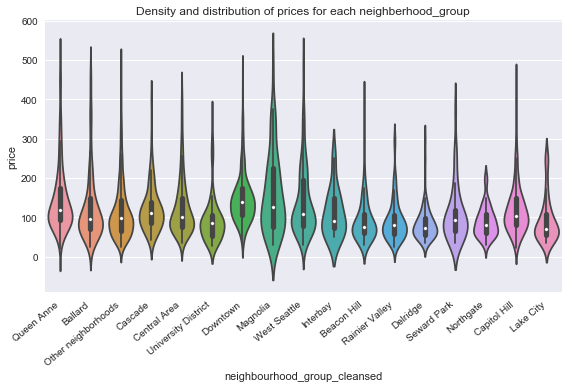

In [231]:
sub_airbnbPrice=airbnb[airbnb.price < 500]
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=sub_airbnbPrice, x='neighbourhood_group_cleansed', y='price', scale = 'width')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')

viz_2.set_xticklabels(viz_2.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [232]:
def recode_prop(value):
        if value in ['Downtown', 'Central Area','Queen Anne','University District','Capitol Hill']:
            return 1.0
        else: 
            return 0.0

airbnb['tourist'] = airbnb['neighbourhood_group_cleansed'].apply(recode_prop)

In [143]:
t = airbnb['tourist']
price = airbnb['price']
apartment = airbnb['property_type_Apartment']
loft = airbnb['property_type_Loft']
bb = airbnb['property_type_Bed & Breakfast']
house = airbnb['property_type_House']
other = airbnb['property_type_Other']
entire = airbnb['room_type_Entire home/apt']
private = airbnb['room_type_Private room']
share = airbnb['room_type_Shared room']

# Relationship using heatmap

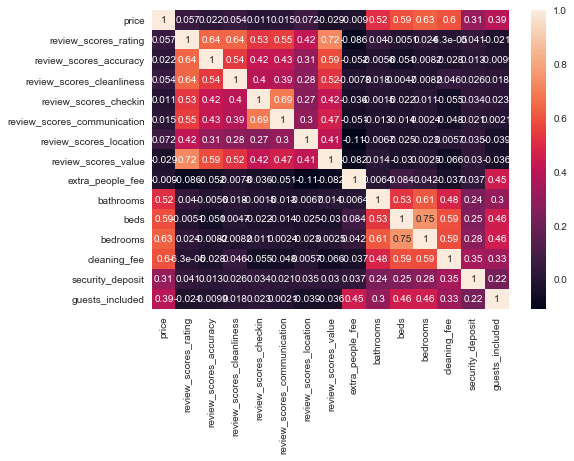

In [233]:
col = ['price','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
        'review_scores_communication', 'review_scores_location', 'review_scores_value', 'extra_people_fee', 'bathrooms'
        ,'beds', 'bedrooms', 'cleaning_fee', 'security_deposit', 'guests_included']
df = airbnb[col]

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

Text(0.5, 1.0, 'The frequency of Cancellation Policy')

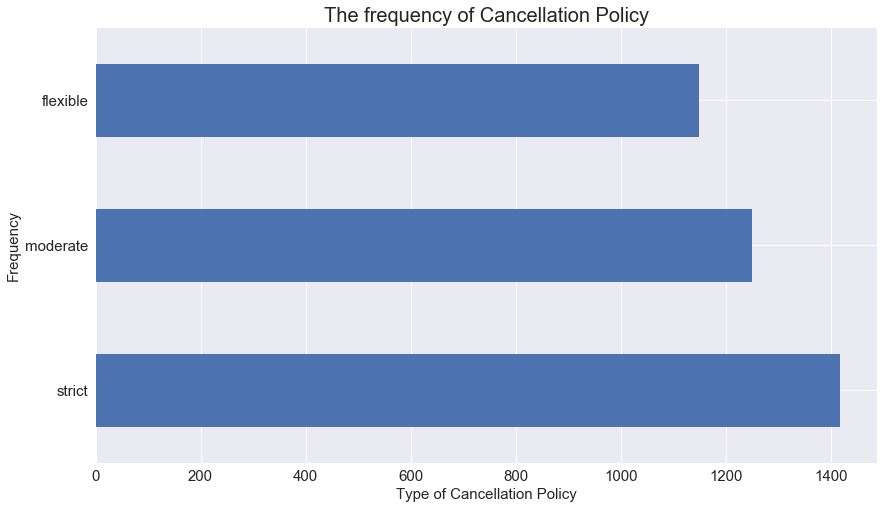

In [234]:
cp = airbnb['cancellation_policy'].value_counts().plot(kind='barh',
                                    figsize=(14,8),
                                    fontsize = 15)
cp.set_xlabel("Type of Cancellation Policy", fontsize = 15)
cp.set_ylabel("Frequency", fontsize = 15)
cp.set_title("The frequency of Cancellation Policy", fontsize = 20)

# Entire Home
This dataframe will only include entire home/apartment observation

In [235]:
# a dataframe for entire home 
entirehome = airbnb[airbnb['room_type']=='Entire home/apt']
entirehome.head()

,id,name,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,accommodates,...,host_verifications_ manual_offline,host_verifications_phone,host_response_rate_buckets,host_since_year,host_year_difference,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,tourist
0,241032,Stylish Queen Anne Apartment,100%,0.0,3.0,1.0,1.0,Queen Anne,Entire home/apt,4,...,0.0,0.0,1,2011.0,5.0,0,0,1,0,1.0
1,953595,Bright & Airy Queen Anne Apartment,100%,1.0,6.0,1.0,1.0,Queen Anne,Entire home/apt,4,...,0.0,0.0,1,2013.0,3.0,0,0,0,1,1.0
2,3308979,New Modern House-Amazing water view,100%,0.0,2.0,1.0,1.0,Queen Anne,Entire home/apt,11,...,0.0,0.0,0,2014.0,2.0,0,0,1,0,1.0
3,7421966,Queen Anne Chateau,NaN,0.0,1.0,1.0,1.0,Queen Anne,Entire home/apt,3,...,0.0,0.0,0,2013.0,3.0,0,0,0,0,1.0
4,278830,Charming craftsman 3 bdm house,NaN,0.0,2.0,1.0,1.0,Queen Anne,Entire home/apt,6,...,0.0,0.0,1,2011.0,5.0,0,0,0,1,1.0


In [236]:
entirehome.neighbourhood_group_cleansed.unique()

array(['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City'], dtype=object)

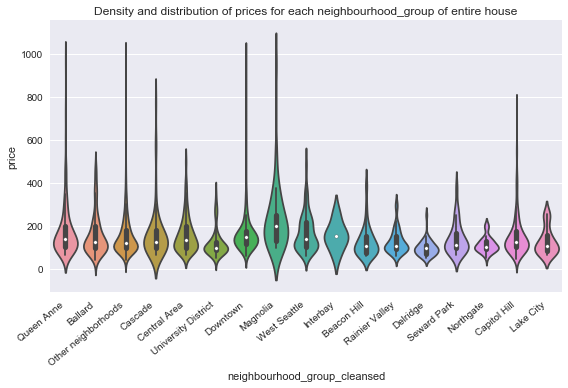

In [237]:
#using violinplot to showcase density and distribtuion of prices of neighbourhood group of entire house
viz_eh=sns.violinplot(data=entirehome, x='neighbourhood_group_cleansed', y='price', scale = 'width')
viz_eh.set_title('Density and distribution of prices for each neighbourhood_group of entire house')

viz_eh.set_xticklabels(viz_eh.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [238]:
#Summary price for entire house in Seattle neighbourhood 
#Queen Anne
sub_1=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Queen Anne']
price_sub1=sub_1[['price']]
#Manhattan
sub_2=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Ballard']
price_sub2=sub_2[['price']]
#Other neighborhoods
sub_3=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Other neighborhoods']
price_sub3=sub_3[['price']]
#Cascade
sub_4=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Cascade']
price_sub4=sub_4[['price']]
#Central Area
sub_5=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Central Area']
price_sub5=sub_5[['price']]
#University District 
sub_6=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'University District']
price_sub6=sub_6[['price']]
#Downtown
sub_7=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Downtown']
price_sub7=sub_7[['price']]
#Magnolia
sub_8=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Magnolia']
price_sub8=sub_8[['price']]
#West Seattle
sub_9=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'West Seattle']
price_sub9=sub_9[['price']]
#Interbay
sub_10=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Interbay']
price_sub10=sub_10[['price']]
#Beacon Hill
sub_11=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Beacon Hill']
price_sub11=sub_11[['price']]
#Rainier Valley
sub_12=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Rainier Valley']
price_sub12=sub_12[['price']]
#Delridge
sub_13=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Delridge']
price_sub13=sub_13[['price']]
#Seward Park
sub_14=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Seward Park']
price_sub14=sub_14[['price']]
#Northgate
sub_15=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Northgate']
price_sub15=sub_15[['price']]
#Capitol Hill
sub_16=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Capitol Hill']
price_sub16=sub_16[['price']]
#Lake City 
sub_17=entirehome.loc[airbnb['neighbourhood_group_cleansed'] == 'Lake City']
price_sub17=sub_17[['price']]
#putting all the prices' dfs in the list
price_list_by_n=[price_sub1, price_sub2, price_sub3, price_sub4, price_sub5, price_sub6, price_sub7,price_sub8,
                 price_sub9, price_sub10,price_sub11,price_sub12,price_sub13,price_sub14,price_sub15, price_sub16,
                 price_sub17]

In [239]:
#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_2=[]

#creating list with known values in neighbourhood_group column
neighborhood_list_eh=['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City']

#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)
    
#changing names of the price column to the area name for easier reading of the table    
p_l_b_n_2[0].rename(columns={'price':neighborhood_list_eh[0]}, inplace=True)
p_l_b_n_2[1].rename(columns={'price':neighborhood_list_eh[1]}, inplace=True)
p_l_b_n_2[2].rename(columns={'price':neighborhood_list_eh[2]}, inplace=True)
p_l_b_n_2[3].rename(columns={'price':neighborhood_list_eh[3]}, inplace=True)
p_l_b_n_2[4].rename(columns={'price':neighborhood_list_eh[4]}, inplace=True)
p_l_b_n_2[5].rename(columns={'price':neighborhood_list_eh[5]}, inplace=True)
p_l_b_n_2[6].rename(columns={'price':neighborhood_list_eh[6]}, inplace=True)
p_l_b_n_2[7].rename(columns={'price':neighborhood_list_eh[7]}, inplace=True)
p_l_b_n_2[8].rename(columns={'price':neighborhood_list_eh[8]}, inplace=True)
p_l_b_n_2[9].rename(columns={'price':neighborhood_list_eh[9]}, inplace=True)
p_l_b_n_2[10].rename(columns={'price':neighborhood_list_eh[10]}, inplace=True)
p_l_b_n_2[11].rename(columns={'price':neighborhood_list_eh[11]}, inplace=True)
p_l_b_n_2[12].rename(columns={'price':neighborhood_list_eh[12]}, inplace=True)
p_l_b_n_2[13].rename(columns={'price':neighborhood_list_eh[13]}, inplace=True)
p_l_b_n_2[14].rename(columns={'price':neighborhood_list_eh[14]}, inplace=True)
p_l_b_n_2[15].rename(columns={'price':neighborhood_list_eh[15]}, inplace=True)
p_l_b_n_2[16].rename(columns={'price':neighborhood_list_eh[16]}, inplace=True)


#finilizing our dataframe for final view    
stat_df=p_l_b_n_2
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Queen Anne,Ballard,Other neighborhoods,Cascade,Central Area,University District,Downtown,Magnolia,West Seattle,Interbay,Beacon Hill,Rainier Valley,Delridge,Seward Park,Northgate,Capitol Hill,Lake City
Stats,,,,,,,,,,,,,,,,,
min,65.0,40.0,39.00,65.00,62.0,47.0,59.0,95.0,59.0,69.0,58.0,59.0,48.0,65.0,50.0,45.00,65.0
25%,100.0,95.0,95.75,95.00,95.0,85.0,114.5,129.0,100.0,150.0,74.0,90.0,70.0,96.5,90.0,99.00,83.5
50%,140.0,122.5,121.00,125.00,135.0,95.0,145.0,200.0,136.0,150.0,104.0,105.0,95.0,110.0,100.0,125.00,106.0
75%,199.5,197.5,180.00,179.75,200.0,125.0,175.0,250.0,219.0,150.0,150.0,150.0,110.0,164.0,129.0,174.25,154.5
max,975.0,475.0,1000.00,775.00,500.0,350.0,999.0,950.0,495.0,250.0,399.0,300.0,250.0,375.0,200.0,750.00,252.0


# Private room 

In [240]:
private = airbnb[airbnb['room_type']=='Private room']
private.head()
print(private.shape)

(1160, 54)


In [241]:
private.neighbourhood_group_cleansed.unique()

array(['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City'], dtype=object)

In [242]:
#Summary price for entire house in Seattle neighbourhood 
#Queen Anne
sub_1=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Queen Anne']
price_sub1=sub_1[['price']]
#Manhattan
sub_2=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Ballard']
price_sub2=sub_2[['price']]
#Other neighborhoods
sub_3=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Other neighborhoods']
price_sub3=sub_3[['price']]
#Cascade
sub_4=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Cascade']
price_sub4=sub_4[['price']]
#Central Area
sub_5=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Central Area']
price_sub5=sub_5[['price']]
#University District 
sub_6=private.loc[airbnb['neighbourhood_group_cleansed'] == 'University District']
price_sub6=sub_6[['price']]
#Downtown
sub_7=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Downtown']
price_sub7=sub_7[['price']]
#Magnolia
sub_8=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Magnolia']
price_sub8=sub_8[['price']]
#West Seattle
sub_9=private.loc[airbnb['neighbourhood_group_cleansed'] == 'West Seattle']
price_sub9=sub_9[['price']]
#Interbay
sub_10=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Interbay']
price_sub10=sub_10[['price']]
#Beacon Hill
sub_11=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Beacon Hill']
price_sub11=sub_11[['price']]
#Rainier Valley
sub_12=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Rainier Valley']
price_sub12=sub_12[['price']]
#Delridge
sub_13=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Delridge']
price_sub13=sub_13[['price']]
#Seward Park
sub_14=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Seward Park']
price_sub14=sub_14[['price']]
#Northgate
sub_15=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Northgate']
price_sub15=sub_15[['price']]
#Capitol Hill
sub_16=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Capitol Hill']
price_sub16=sub_16[['price']]
#Lake City 
sub_17=private.loc[airbnb['neighbourhood_group_cleansed'] == 'Lake City']
price_sub17=sub_17[['price']]
#putting all the prices' dfs in the list
price_list_by_p=[price_sub1, price_sub2, price_sub3, price_sub4, price_sub5, price_sub6, price_sub7,price_sub8,
                 price_sub9, price_sub10,price_sub11,price_sub12,price_sub13,price_sub14,price_sub15, price_sub16,
                 price_sub17]

In [243]:
#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_4=[]

#creating list with known values in neighbourhood_group column
neighborhood_list_p=['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City']

#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_p:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_4.append(i)
    
#changing names of the price column to the area name for easier reading of the table    
p_l_b_n_4[0].rename(columns={'price':neighborhood_list_p[0]}, inplace=True)
p_l_b_n_4[1].rename(columns={'price':neighborhood_list_p[1]}, inplace=True)
p_l_b_n_4[2].rename(columns={'price':neighborhood_list_p[2]}, inplace=True)
p_l_b_n_4[3].rename(columns={'price':neighborhood_list_p[3]}, inplace=True)
p_l_b_n_4[4].rename(columns={'price':neighborhood_list_p[4]}, inplace=True)
p_l_b_n_4[5].rename(columns={'price':neighborhood_list_p[5]}, inplace=True)
p_l_b_n_4[6].rename(columns={'price':neighborhood_list_p[6]}, inplace=True)
p_l_b_n_4[7].rename(columns={'price':neighborhood_list_p[7]}, inplace=True)
p_l_b_n_4[8].rename(columns={'price':neighborhood_list_p[8]}, inplace=True)
p_l_b_n_4[9].rename(columns={'price':neighborhood_list_p[9]}, inplace=True)
p_l_b_n_4[10].rename(columns={'price':neighborhood_list_p[10]}, inplace=True)
p_l_b_n_4[11].rename(columns={'price':neighborhood_list_p[11]}, inplace=True)
p_l_b_n_4[12].rename(columns={'price':neighborhood_list_p[12]}, inplace=True)
p_l_b_n_4[13].rename(columns={'price':neighborhood_list_p[13]}, inplace=True)
p_l_b_n_4[14].rename(columns={'price':neighborhood_list_p[14]}, inplace=True)
p_l_b_n_4[15].rename(columns={'price':neighborhood_list_p[15]}, inplace=True)
p_l_b_n_4[16].rename(columns={'price':neighborhood_list_p[16]}, inplace=True)


#finilizing our dataframe for final view    
stat_df=p_l_b_n_4
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Queen Anne,Ballard,Other neighborhoods,Cascade,Central Area,University District,Downtown,Magnolia,West Seattle,Interbay,Beacon Hill,Rainier Valley,Delridge,Seward Park,Northgate,Capitol Hill,Lake City
Stats,,,,,,,,,,,,,,,,,
min,20.0,25.0,26.0,42.00,35.0,28.0,40.00,40.0,39.0,50.00,35.0,25.0,35.0,34.0,36.0,39.0,35.00
25%,75.0,53.5,50.0,59.00,60.0,41.0,75.00,50.0,59.0,58.50,50.0,48.5,50.0,39.0,55.0,69.0,50.00
50%,86.5,65.0,62.0,75.00,70.0,47.0,89.50,69.0,75.0,75.00,60.0,60.0,59.5,63.0,60.0,84.0,55.00
75%,100.0,76.5,80.0,100.75,90.0,65.0,118.75,76.5,89.0,86.25,79.0,70.0,71.5,68.0,70.0,104.5,62.75
max,225.0,125.0,280.0,220.00,175.0,120.0,250.00,99.0,399.0,95.00,169.0,150.0,300.0,93.0,150.0,220.0,200.00


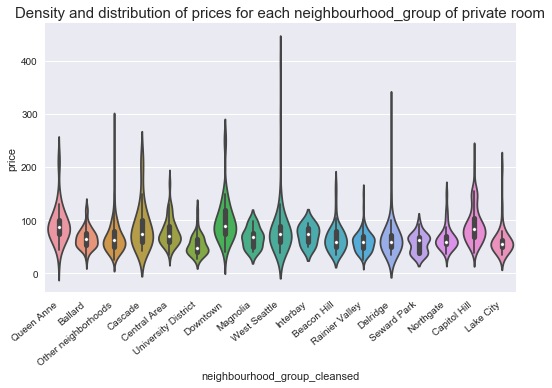

In [244]:
#using violinplot to showcase density and distribtuion of prices of neighbourhood group of private room
viz_p=sns.violinplot(data=private, x='neighbourhood_group_cleansed', y='price', scale = 'width')
viz_p.set_title('Density and distribution of prices for each neighbourhood_group of private room', fontsize = 15)

viz_p.set_xticklabels(viz_eh.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Shared room

In [245]:
share = airbnb[airbnb['room_type']=='Shared room']
print(share.shape)

(117, 54)


In [246]:
share.neighbourhood_group_cleansed.unique()

array(['Queen Anne', 'Other neighborhoods', 'Central Area',
       'University District', 'Downtown', 'Cascade', 'Magnolia',
       'West Seattle', 'Beacon Hill', 'Rainier Valley', 'Northgate',
       'Capitol Hill'], dtype=object)

In [247]:
#Summary price for entire house in Seattle neighbourhood 
#Queen Anne
sub_1=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Queen Anne']
price_sub1=sub_1[['price']]
#Other neighborhoods
sub_2=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Other neighborhoods']
price_sub2=sub_2[['price']]
#Central Area
sub_3=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Central Area']
price_sub3=sub_3[['price']]
#University District 
sub_4=share.loc[airbnb['neighbourhood_group_cleansed'] == 'University District']
price_sub4=sub_4[['price']]
#Downtown
sub_5=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Downtown']
price_sub5=sub_5[['price']]
#Magnolia
sub_6=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Magnolia']
price_sub6=sub_6[['price']]
#West Seattle
sub_7=share.loc[airbnb['neighbourhood_group_cleansed'] == 'West Seattle']
price_sub7=sub_7[['price']]
#Interbay
sub_8=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Cascade']
price_sub8=sub_8[['price']]
#Beacon Hill
sub_9=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Beacon Hill']
price_sub9=sub_9[['price']]
#Rainier Valley
sub_10=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Rainier Valley']
price_sub10=sub_10[['price']]
#Northgate
sub_11=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Northgate']
price_sub11=sub_11[['price']]
#Capitol Hill
sub_12=share.loc[airbnb['neighbourhood_group_cleansed'] == 'Capitol Hill']
price_sub12=sub_12[['price']]
#putting all the prices' dfs in the list
price_list_by_s=[price_sub1, price_sub2, price_sub3, price_sub4, price_sub5, price_sub6, price_sub7,price_sub8,
                 price_sub9, price_sub10,price_sub11,price_sub12]

In [248]:
#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_3=[]

#creating list with known values in neighbourhood_group column
neighborhood_list_s=['Queen Anne', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Beacon Hill', 'Rainier Valley', 'Northgate', 'Capitol Hill']

#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_s:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_3.append(i)
    
#changing names of the price column to the area name for easier reading of the table    
p_l_b_n_3[0].rename(columns={'price':neighborhood_list_s[0]}, inplace=True)
p_l_b_n_3[1].rename(columns={'price':neighborhood_list_s[1]}, inplace=True)
p_l_b_n_3[2].rename(columns={'price':neighborhood_list_s[2]}, inplace=True)
p_l_b_n_3[3].rename(columns={'price':neighborhood_list_s[3]}, inplace=True)
p_l_b_n_3[4].rename(columns={'price':neighborhood_list_s[4]}, inplace=True)
p_l_b_n_3[5].rename(columns={'price':neighborhood_list_s[5]}, inplace=True)
p_l_b_n_3[6].rename(columns={'price':neighborhood_list_s[6]}, inplace=True)
p_l_b_n_3[7].rename(columns={'price':neighborhood_list_s[7]}, inplace=True)
p_l_b_n_3[8].rename(columns={'price':neighborhood_list_s[8]}, inplace=True)
p_l_b_n_3[9].rename(columns={'price':neighborhood_list_s[9]}, inplace=True)
p_l_b_n_3[10].rename(columns={'price':neighborhood_list_s[10]}, inplace=True)
p_l_b_n_3[11].rename(columns={'price':neighborhood_list_s[11]}, inplace=True)

#finilizing our dataframe for final view    
stat_df=p_l_b_n_3
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Queen Anne,Other neighborhoods,Cascade,Central Area,University District,Downtown,Magnolia,West Seattle,Beacon Hill,Rainier Valley,Northgate,Capitol Hill
Stats,,,,,,,,,,,,
min,38.00,25.0,40.00,29.0,35.0,30.0,30.0,50.0,30.0,40.00,30.00,22.0
25%,38.25,40.0,54.25,42.0,40.0,30.0,30.0,75.0,37.5,40.00,33.75,29.0
50%,38.50,40.0,59.50,42.0,45.0,30.0,30.0,100.0,45.0,42.50,36.00,39.5
75%,38.75,40.5,64.75,50.0,65.0,30.0,30.0,100.0,50.0,56.25,40.25,53.5
max,39.00,76.0,79.00,118.0,95.0,30.0,30.0,100.0,55.0,90.00,50.00,100.0


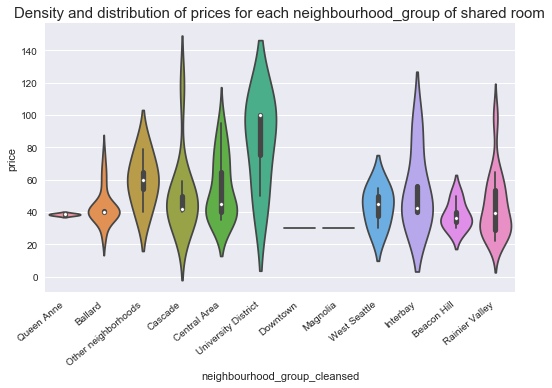

In [249]:
#using violinplot to showcase density and distribtuion of prices of neighbourhood group of private room
viz_s=sns.violinplot(data=share, x='neighbourhood_group_cleansed', y='price', scale = 'width')
viz_s.set_title('Density and distribution of prices for each neighbourhood_group of shared room', fontsize = 15)

viz_s.set_xticklabels(viz_eh.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

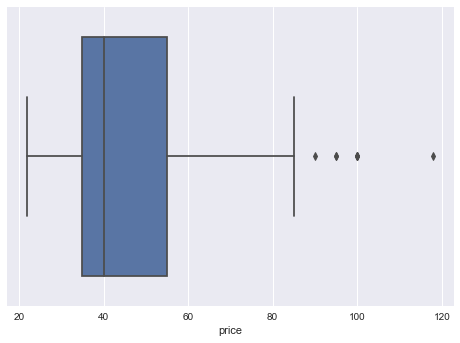

In [250]:
sns.boxplot(x=share['price'])

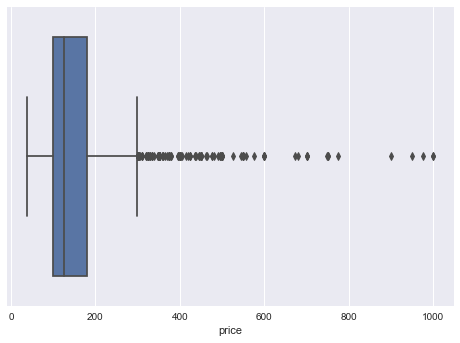

In [251]:
sns.boxplot(x=entirehome['price'])

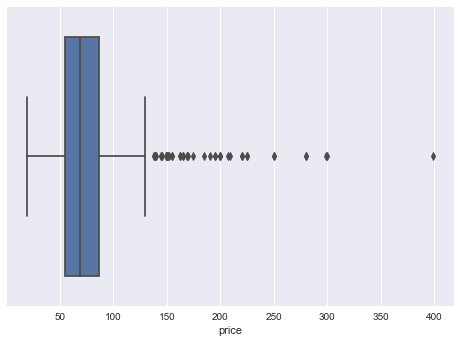

In [252]:
sns.boxplot(x=private['price'])

# Relationship between price, bedrooms and beds

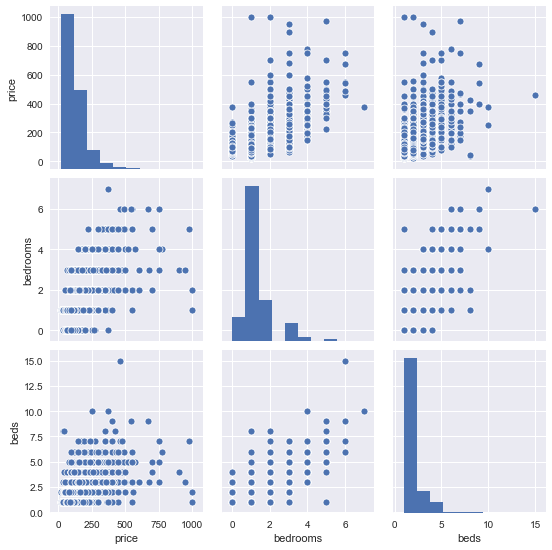

In [253]:
airbnb.corr()
df_a = airbnb[['price','bedrooms', 'beds']]

sns.pairplot(df_a, kind="scatter")
plt.show()

# Distribution of the plot

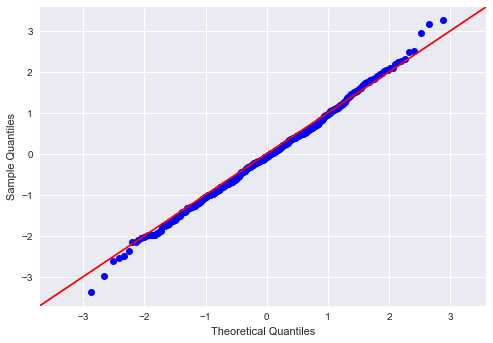

In [254]:
qq = pd.DataFrame(airbnb, columns=['price'])
qq = norm.rvs(size=500)
sm.qqplot(qq, line='45')
pylab.show()

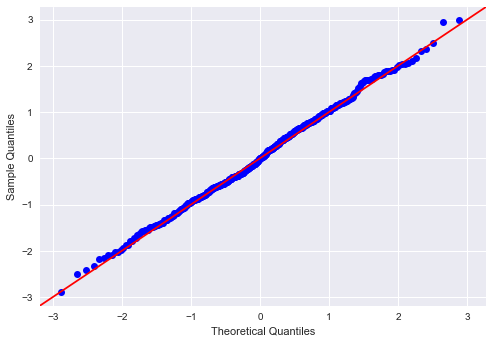

In [255]:
eh = pd.DataFrame(entirehome, columns=['price'])
eh = norm.rvs(size=500)
sm.qqplot(eh, line='45')
pylab.show()

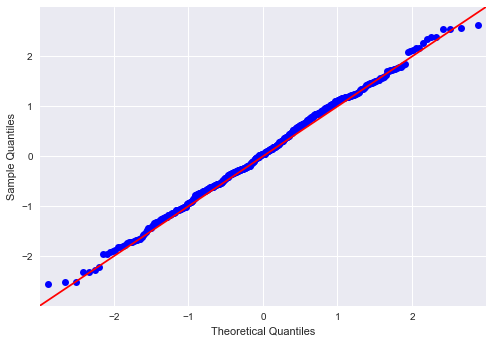

In [256]:
qq_s= pd.DataFrame(share, columns=['price'])
qq_s = norm.rvs(size=500)
sm.qqplot(qq_s, line='45')
pylab.show()

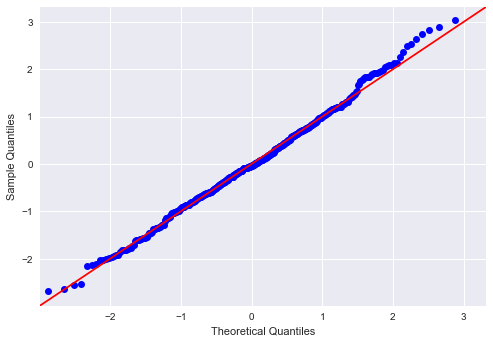

In [257]:
pr= pd.DataFrame(private, columns=['price'])
pr = norm.rvs(size=500)
sm.qqplot(pr, line='45')
pylab.show()

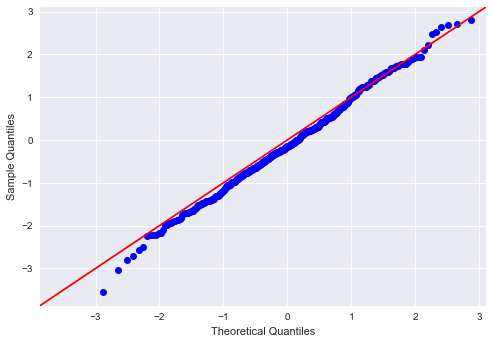

In [259]:
available= pd.DataFrame(airbnb, columns=['availability_30'])
available= norm.rvs(size=500)
sm.qqplot(available, line='45')
pylab.show()

In [260]:
qq = pd.DataFrame(airbnb, columns=['price'])
qq = norm.rvs(size=500)
stat, p = shapiro(qq)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.997, p=0.522


In [261]:
qq_s = pd.DataFrame(share, columns=['price'])
qq_s= norm.rvs(size=500)
stat, p = shapiro(qq_s)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.998, p=0.867


In [262]:
eh = pd.DataFrame(entirehome, columns=['price'])
eh = norm.rvs(size=500)
stat, p = shapiro(eh)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.996, p=0.258


In [263]:
pr = pd.DataFrame(private, columns=['price'])
pr = norm.rvs(size=500)
stat, p = shapiro(pr)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.996, p=0.255


In [265]:
available = pd.DataFrame(airbnb, columns=['availability_30'])
available = norm.rvs(size=500)
stat, p = shapiro(available)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.996, p=0.267


# Room Type 

In [266]:
airbnb = pd.get_dummies(airbnb, columns=['room_type'])

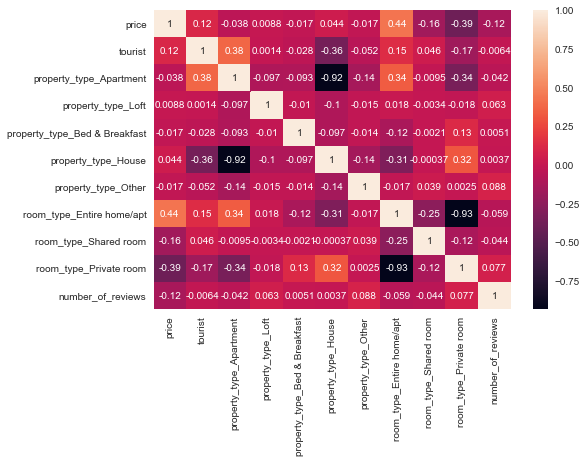

In [267]:
col = ['price','tourist', 'property_type_Apartment', 'property_type_Loft', 'property_type_Bed & Breakfast', 'property_type_House'
       , 'property_type_Other', 'room_type_Entire home/apt', 'room_type_Shared room', 'room_type_Private room', 'number_of_reviews']
df = airbnb[col]
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

In [268]:
airbnb.to_csv('/Users/bernicelow/Documents/capstone/FINISH.csv')